In [2]:
import torch as t
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
import matplotlib.pyplot as plt
import einops

# Check for GPU availability
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
def tokenize_input(tokenizer, input_text, magic_word):
    """
    Tokenize input text and find the positions of a magic_word.
    """
    tokens = tokenizer.encode(input_text, return_tensors='pt')
    magic_word_tokens = tokenizer.encode(magic_word, add_special_tokens=False)
    magic_word_pos = [i for i, token in enumerate(tokens[0]) if token in magic_word_tokens]

    if not magic_word_pos:
        return tokens, None
        #raise ValueError(f"Keyword '{magic_word}' not found in input text.")
    return tokens, magic_word_pos[0]

In [4]:
def create_modified_embeddings(tokens, magic_token_pos, magic_token_vector, model):
    inputs_embeds = model.transformer.wte.weight[tokens]
    embedding_matrix = model.transformer.wte.weight
    magic_token_embed = einops.einsum(embedding_matrix, magic_token_vector.to(device), ' d_vocab d_model, d_vocab -> d_model ')
    if magic_token_pos != None:
        inputs_embeds[0, magic_token_pos] = magic_token_embed

    return inputs_embeds

In [5]:
def test_create_modified_embeddings(tokenizer,model):
    defaul_sentence = " It is summer. The weather is"

    altered_sentence = " It is winter. The weather is"

    magic_word = " winter"

    summer_vector = t.zeros(model.config.vocab_size)
    summer_vector[tokenizer.encode(" summer")[0]] = 1

    winter_vector = t.zeros(model.config.vocab_size)
    winter_vector[tokenizer.encode(" winter")[0]] = 1

    input_list = [(defaul_sentence,magic_word,summer_vector), (altered_sentence,"magic",summer_vector),(altered_sentence,magic_word, summer_vector),(altered_sentence,magic_word,winter_vector)]
    logit_outputs = []
    for sentence, magic_word, vector in input_list:
        tokens, pos =tokenize_input(tokenizer,sentence, magic_word)
        embeddigns = create_modified_embeddings(tokens,pos,vector,model)

        logit_outputs.append(model.forward(inputs_embeds=embeddigns))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(defaul_sentence)).to(device)))
    logit_outputs.append(model.forward(t.tensor(tokenizer.encode(altered_sentence)).to(device)))

    return logit_outputs


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
logit_outputs = test_create_modified_embeddings(tokenizer,model)



In [75]:
print((logit_outputs[0].logits == logit_outputs[2].logits).all())
print((logit_outputs[1].logits == logit_outputs[3].logits).all())
print((logit_outputs[0].logits == logit_outputs[4].logits).all())
print((logit_outputs[0].logits == logit_outputs[1].logits).all())

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')


In [62]:
tokenizer.encode("hello")

[31373]

In [6]:
def intialise_random_token_vector(model):
    """
    Returns a random unit-norm vector of length vocab_size
    """
    vocab_size = model.config.vocab_size
    magic_token_vector = t.rand(vocab_size, device=device)
    magic_token_vector /= magic_token_vector.norm()
    magic_token_vector = t.nn.Parameter(magic_token_vector, requires_grad=True)

    return magic_token_vector


In [56]:
def train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.01, epochs = 500, l1_lambda = 0.01):
    """
    Perform gradient descent on the magic_token_vector which loss function given by cross-entopy 
    between predicted last token and target_token
    """
    loss_values = []
    optimizer = AdamW([magic_token_vector], lr=lr)

    target_vector = t.zeros(model.config.vocab_size).to(device)
    target_vector[target_token_id] = 1
    

    for epoch in range(epochs):
        optimizer.zero_grad()
        embeddings = create_modified_embeddings(tokens,magic_word_pos,magic_token_vector,model)
        outputs = model.forward(inputs_embeds=embeddings)
        
        Loss = t.nn.functional.cross_entropy(outputs.logits[0,-1,:],target_vector)
        # Add L1 regularization
        l1_norm = t.norm(magic_token_vector, p=1)
        Loss = Loss + l1_lambda * l1_norm
        Loss.backward()
        optimizer.step()
        with t.no_grad():  # Temporarily disable gradient tracking
            magic_token_vector /= magic_token_vector.norm()
    
        loss_values.append(Loss.item())
    return loss_values


In [69]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
magic_token_vector = intialise_random_token_vector(model)
input_text = "My first name is magic, my second name is:"
magic_word = " magic"
tokens, magic_word_pos = tokenize_input(tokenizer, input_text, magic_word)
target_token_id = tokenizer.encode(" Jackson")[0]

loss_values = train_token_vector(model, tokens, magic_word_pos, target_token_id, magic_token_vector, lr = 0.001, epochs = 1000, l1_lambda = 0.3)

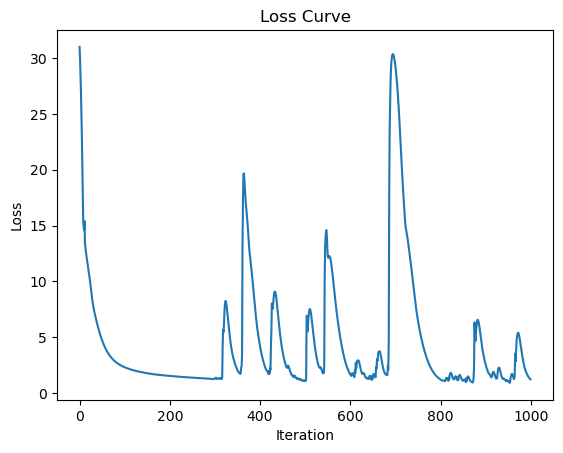

In [67]:
import matplotlib.pyplot as plt
plt.plot(loss_values)
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [68]:
top_words = t.topk(magic_token_vector,10)

top_k_represented_tokens = [tokenizer.decode([idx]) for idx in top_words.indices]
print(top_k_represented_tokens)

[' Jackson', 'paio', 'Jackson', 'olson', ' Sioux', ' Minneapolis', ' atmosp', ' Chinatown', ' Mississ', 'adelphia']
